<a href="https://colab.research.google.com/github/clferreira1985/Projetos_Python/blob/main/RNN_Animal10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Sprint 2 B -Machine Learning e Analytics

### Profs Hugo Villamizar e Patric Happ

#### Aluno: Cleiton Silva


## 1. Imports das bibliotecas necessárias para executar o notebook

In [21]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import random
import math
import shutil
from PIL import Image
from datetime import datetime
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight, shuffle
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import itertools


## 2. Acessando e tratando os dados que serão a entrada do modelo de deep learning

No caso abaixo, as imagens estão organizadas em pastas dentro do meu google drive. Crio um dataset com as informações das imagens

In [2]:
# Vamos pegar todos os arquivos dentro da pasta que armazenei todas as imagens e transformar em um dataset
%%time
folder_path = r"/content/drive/MyDrive/Puc - Pós em Ciência de Dados e Analytics /Redes Neurais/Dataset/Animais"

data = {"path_img": [] , "heights": [], "widths": [], "animal": []  }

category = os.listdir(folder_path)
for folder in category:
    folderpath = os.path.join(folder_path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["path_img"].append(fpath)
        data["animal"].append(folder)
        img_shape = Image.open(fpath)
        data["heights"].append(img_shape.size[0])
        data["widths"].append(img_shape.size[1])

df = pd.DataFrame(data)


CPU times: user 5.01 s, sys: 2.94 s, total: 7.95 s
Wall time: 7min 23s


In [3]:
#Convert animal to numbers
lb = LabelEncoder()
df['encoded_animal'] = lb.fit_transform(df['animal'])


In [4]:
#Vamos mudar os nomes das linhas labels, para entender melhor
translate = {"mucca": "vaca",
             "cavallo": "cavalo",
             "farfalla": "borboleta",
             "cane": "cachorro",
             "gallina": "galinha",
             "gatto": "gato",
             "elefante": "elefante",
             "pecora":"ovelha",
             "scoiattolo":"esquilo",
             "ragno":"aranha"}

df['animal']=df['animal'].map(translate)
df['animal'].unique()


array(['vaca', 'cavalo', 'aranha', 'borboleta', 'ovelha', 'cachorro',
       'galinha', 'gato', 'elefante', 'esquilo'], dtype=object)

In [5]:
#Crio um resumo do dataset criado

print("Tamanho do dataset: ", df.shape)
print("_______________________________________")
print("Valores null: ")
print(df.isnull().sum())
print("_______________________________________")
print("Valores únicos: ")
print(df.nunique())

print("_______________________________________")
print("Qnt de imagens por categoria : ")
print(df.animal.value_counts())

print("_______________________________________")
print("Informação do dataset: ")
print(df.info())

Tamanho do dataset:  (21708, 5)
_______________________________________
Valores null: 
path_img          0
heights           0
widths            0
animal            0
encoded_animal    0
dtype: int64
_______________________________________
Valores únicos: 
path_img          21708
heights             278
widths              453
animal               10
encoded_animal       10
dtype: int64
_______________________________________
Qnt de imagens por categoria : 
cachorro     4863
galinha      3098
cavalo       2623
borboleta    2112
vaca         1866
esquilo      1862
ovelha       1820
gato         1668
elefante     1446
aranha        350
Name: animal, dtype: int64
_______________________________________
Informação do dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21708 entries, 0 to 21707
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path_img        21708 non-null  object
 1   heights         21708 

In [6]:
df.head()

path_img  heights  widths animal  \
0  /content/drive/MyDrive/Puc - Pós em Ciência ...      300     209   vaca   
1  /content/drive/MyDrive/Puc - Pós em Ciência ...      300     225   vaca   
2  /content/drive/MyDrive/Puc - Pós em Ciência ...      300     225   vaca   
3  /content/drive/MyDrive/Puc - Pós em Ciência ...      300     192   vaca   
4  /content/drive/MyDrive/Puc - Pós em Ciência ...      300     156   vaca   

   encoded_animal  
0               6  
1               6  
2               6  
3               6  
4               6

<Axes: title={'center': 'Como está distribuido o dataset'}, ylabel='animal'>

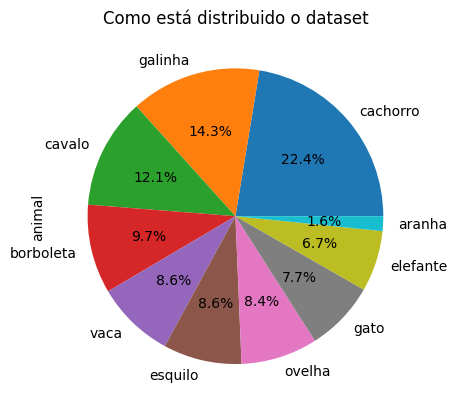

In [7]:
#Visualizando como está dividido o conjunto de dados por classe
df['animal'].value_counts().plot.pie(title='Como está distribuido o dataset', autopct='%1.1f%%')

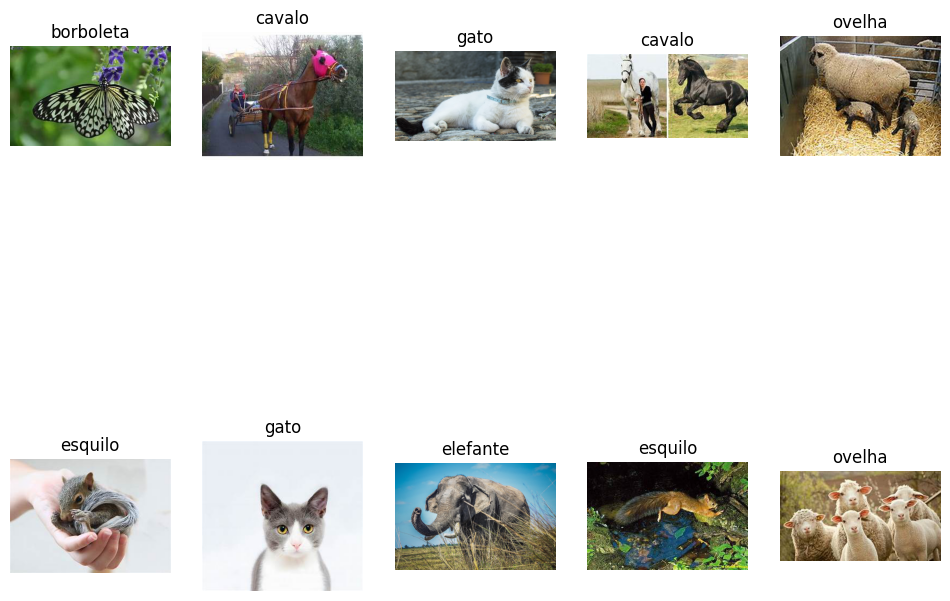

In [8]:
#visualizando algumas imagens do conjunto de dados
plt.figure(figsize=(12,10))
for i, row in df.sample(n=10).reset_index().iterrows():
    plt.subplot(2,5,i+1)
    image_path = row['path_img']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["animal"])
    plt.axis('off')
plt.show()

Divisão dos dados em treino e teste: 30% das imagens para teste e 70 para treino do modelo de deep learning.

In [9]:
df_train, df_test = train_test_split(df[['path_img', 'animal']].reset_index(drop=True), test_size=0.3, random_state=30, shuffle=True)



In [10]:
#Resumo da separação do conjunto de dados
print("#########Train##############")
print(df_train.head())
print(df_train.shape)
print("#########Test###############")
print(df_test.head())
print(df_test.shape)

#########Train##############
                                                path_img     animal
141    /content/drive/MyDrive/Puc - Pós em Ciência ...       vaca
2309   /content/drive/MyDrive/Puc - Pós em Ciência ...     cavalo
12115  /content/drive/MyDrive/Puc - Pós em Ciência ...   cachorro
5355   /content/drive/MyDrive/Puc - Pós em Ciência ...  borboleta
17502  /content/drive/MyDrive/Puc - Pós em Ciência ...       gato
(15195, 2)
#########Test###############
                                                path_img    animal
9799   /content/drive/MyDrive/Puc - Pós em Ciência ...  cachorro
20660  /content/drive/MyDrive/Puc - Pós em Ciência ...   esquilo
12944  /content/drive/MyDrive/Puc - Pós em Ciência ...  cachorro
18548  /content/drive/MyDrive/Puc - Pós em Ciência ...  elefante
11133  /content/drive/MyDrive/Puc - Pós em Ciência ...  cachorro
(6513, 2)


#### Preparação dos dados

Através da classe **ImageDataGenerator** do TensorFlow iremos configurar geradores de dados para o treinamento, validação, e teste

In [11]:
%%time

BATCH_SIZE = 50 #Defino o tamanho do lote
IMAGE_SIZE = (150, 150) #Defino o tamanho das imagens

train_datagen=ImageDataGenerator(validation_split=0.3, #include validation split
                                 rescale = 1.0/255,
                                 rotation_range=90,#defino o intervalo de rotação 90º
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest' # Por padrão é 'mais próximo'. Pontos fora dos limites da entrada são preenchidos de acordo com o modo dado
                                 )

test_datagen=ImageDataGenerator(rescale=1./255)


train_generator=train_datagen.flow_from_dataframe(
    dataframe=df_train,
    target_size= IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    x_col='path_img',
    y_col='animal',
    subset='training' #training set
    )

val_generator=train_datagen.flow_from_dataframe(
    dataframe=df_train,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    x_col='path_img',
    y_col='animal',
    subset='validation' #validation set
    )

test_generator=test_datagen.flow_from_dataframe(
    dataframe = df_test,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    x_col='path_img',
    y_col='animal',)

Found 10637 validated image filenames belonging to 10 classes.
Found 4558 validated image filenames belonging to 10 classes.
Found 6513 validated image filenames belonging to 10 classes.
CPU times: user 867 ms, sys: 1.84 s, total: 2.71 s
Wall time: 10.2 s


Found 1 validated image filenames belonging to 1 classes.


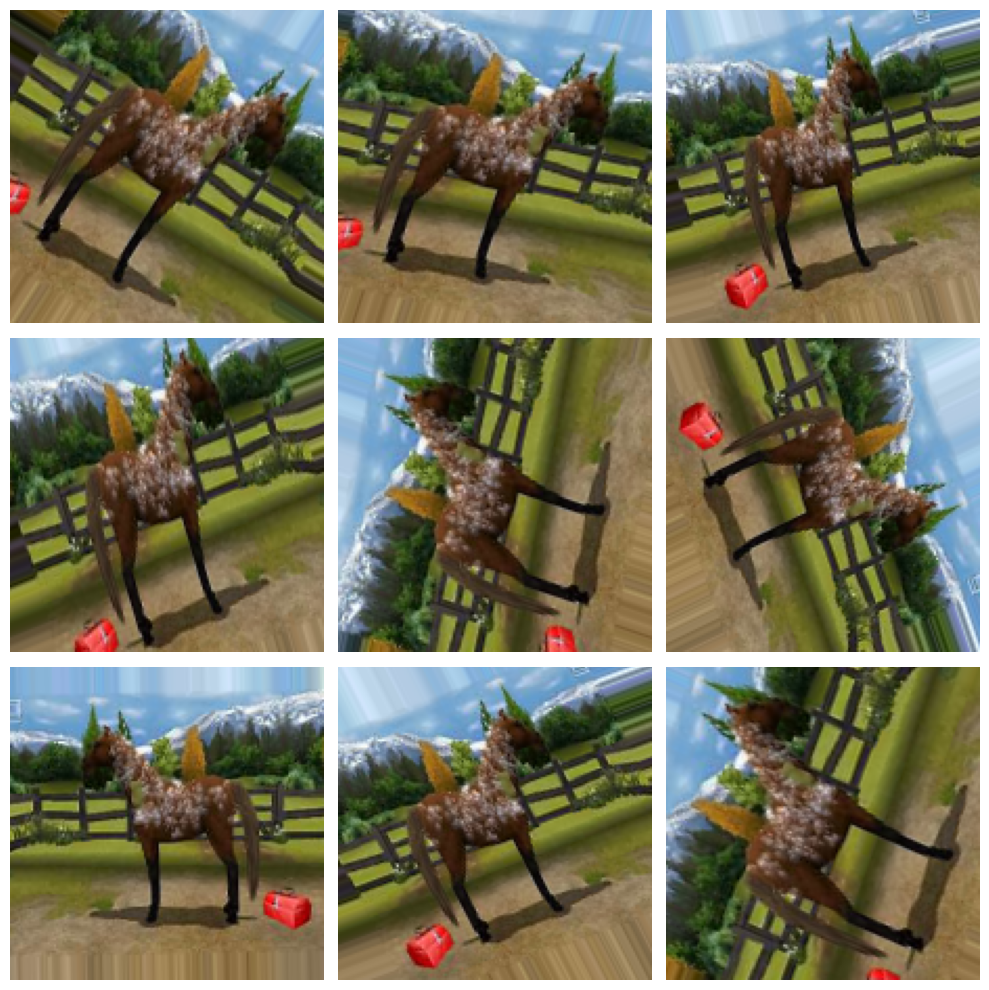

In [12]:
#Visualizo uma imagem com o class_mode="categorical"
sample = df.sample(n=1)

sample_generator = train_datagen.flow_from_dataframe(
    dataframe = sample,
    x_col='path_img',
    y_col='animal',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in sample_generator:
        image = x_batch[0]
        plt.imshow(image)
        plt.axis('Off')
        break
plt.tight_layout()
plt.show()

## Configuração de um modelo de deep learning usando uma rede neural convolucional (CNN)

In [13]:
model=models.Sequential([
    layers.Conv2D(16 ,(3,3) , activation='relu' , input_shape=(150,150,3 ) ) ,
    layers.MaxPooling2D( (2,2)),
    layers.Conv2D(32 , (3,3) , activation='relu'),
    layers.MaxPooling2D( (2,2)),
    layers.Conv2D(128 , (3,3) , activation='relu'),
    layers.MaxPooling2D( (2,2)),
    layers.Flatten(),
    layers.Dense( 512 ,activation='relu' ),
    layers.Dense( 256 ,activation='relu' ),
    layers.Dense( 10 , activation='softmax'),
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## 4. Treinamento do modelo de deep learning

In [23]:
%%time

model.compile(optimizer=Adam(learning_rate = 0.0001), loss='categorical_crossentropy' , metrics=['accuracy'])

history=model.fit_generator(train_generator,
                            steps_per_epoch=len(train_generator),
                            epochs=10,
                            validation_data=val_generator ,
                            validation_steps=len(val_generator),
                            callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc')])

<timed exec>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
213/213 [==============================] - ETA: 0s - loss: 1.5308 - accuracy: 0.4650

213/213 [==============================] - 343s 2s/step - loss: 1.5308 - accuracy: 0.4650 - val_loss: 1.5122 - val_accuracy: 0.4831
Epoch 2/10
213/213 [==============================] - ETA: 0s - loss: 1.4824 - accuracy: 0.4839

213/213 [==============================] - 335s 2s/step - loss: 1.4824 - accuracy: 0.4839 - val_loss: 1.5082 - val_accuracy: 0.4930
Epoch 3/10
213/213 [==============================] - ETA: 0s - loss: 1.4595 - accuracy: 0.4896

213/213 [==============================] - 360s 2s/step - loss: 1.4595 - accuracy: 0.4896 - val_loss: 1.4795 - val_accuracy: 0.4943
Epoch 4/10
213/213 [==============================] - ETA: 0s - loss: 1.4232 - accuracy: 0.5035

213/213 [==============================] - 355s 2s/step - loss: 1.4232 - accuracy: 0.5035 - val_loss: 1.4192 - val_accuracy: 0.5118
Epoch 5/10
213/213 [==============================] - ETA: 0s - loss: 1.4089 - accuracy: 0.5110

213/213 [==============================] - 367s 2s/step - loss: 1.4089 - accuracy: 0.5110 - val_loss: 1.4434 - val_accuracy: 0.4969
Epoch 6/10
213/213 [==============================] - ETA: 0s - loss: 1.3774 - accuracy: 0.5218

213/213 [==============================] - 357s 2s/step - loss: 1.3774 - accuracy: 0.5218 - val_loss: 1.3788 - val_accuracy: 0.5276
Epoch 7/10
213/213 [==============================] - ETA: 0s - loss: 1.3499 - accuracy: 0.5316

213/213 [==============================] - 359s 2s/step - loss: 1.3499 - accuracy: 0.5316 - val_loss: 1.3543 - val_accuracy: 0.5342
Epoch 8/10
213/213 [==============================] - ETA: 0s - loss: 1.3255 - accuracy: 0.5437

213/213 [==============================] - 362s 2s/step - loss: 1.3255 - accuracy: 0.5437 - val_loss: 1.3282 - val_accuracy: 0.5417
Epoch 9/10
213/213 [==============================] - ETA: 0s - loss: 1.3132 - accuracy: 0.5440

213/213 [==============================] - 339s 2s/step - loss: 1.3132 - accuracy: 0.5440 - val_loss: 1.3407 - val_accuracy: 0.5312
Epoch 10/10
213/213 [==============================] - ETA: 0s - loss: 1.2860 - accuracy: 0.5558

213/213 [==============================] - 361s 2s/step - loss: 1.2860 - accuracy: 0.5558 - val_loss: 1.3180 - val_accuracy: 0.5513
CPU times: user 1h 21min 55s, sys: 7min 13s, total: 1h 29min 9s
Wall time: 1h 6s


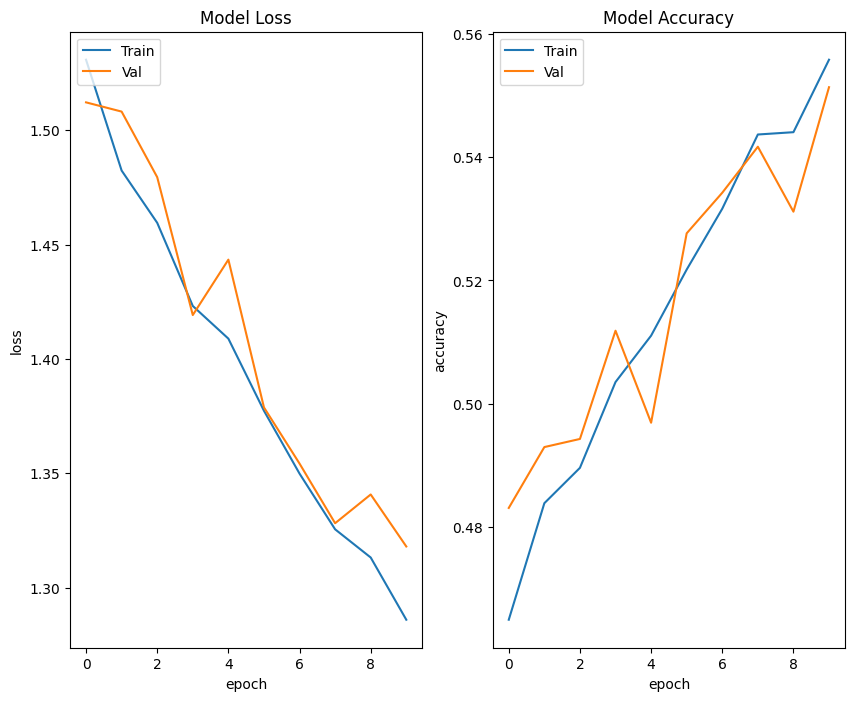

In [24]:
f, ax = plt.subplots(1,2,figsize=(10,8))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Val'], loc='upper left')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Val'], loc='upper left')

plt.show()

In [25]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))


<ipython-input-25-78954c843b8c>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(test_generator)


Test: accuracy = 0.472593  ;  loss = 1.603490 


In [26]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis = 1)
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

131/131 [==============================] - 51s 390ms/step
F1 Score: 0.11912067118892725
              precision    recall  f1-score   support

      aranha       0.01      0.01      0.01        97
   borboleta       0.09      0.11      0.10       624
    cachorro       0.23      0.19      0.21      1460
      cavalo       0.11      0.05      0.07       777
    elefante       0.05      0.02      0.03       447
     esquilo       0.08      0.10      0.09       576
     galinha       0.15      0.34      0.21       925
        gato       0.06      0.03      0.04       490
      ovelha       0.07      0.09      0.08       568
        vaca       0.12      0.04      0.06       549

    accuracy                           0.13      6513
   macro avg       0.10      0.10      0.09      6513
weighted avg       0.13      0.13      0.12      6513



In [27]:
classes = dict(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index": list(range(len(test_generator.labels))),
                            "Test Labels": test_generator.labels,
                            "Test Classes": [classes[i] for i in test_generator.labels],
                            "Prediction Labels": y_pred,
                            "Prediction Classes": [classes[i] for i in y_pred],
                            "Path": test_generator.filepaths,
                            "Prediction Probability": [x for x in np.asarray(np.max(model.predict(test_generator), axis=1))]
                           })

131/131 [==============================] - 54s 409ms/step


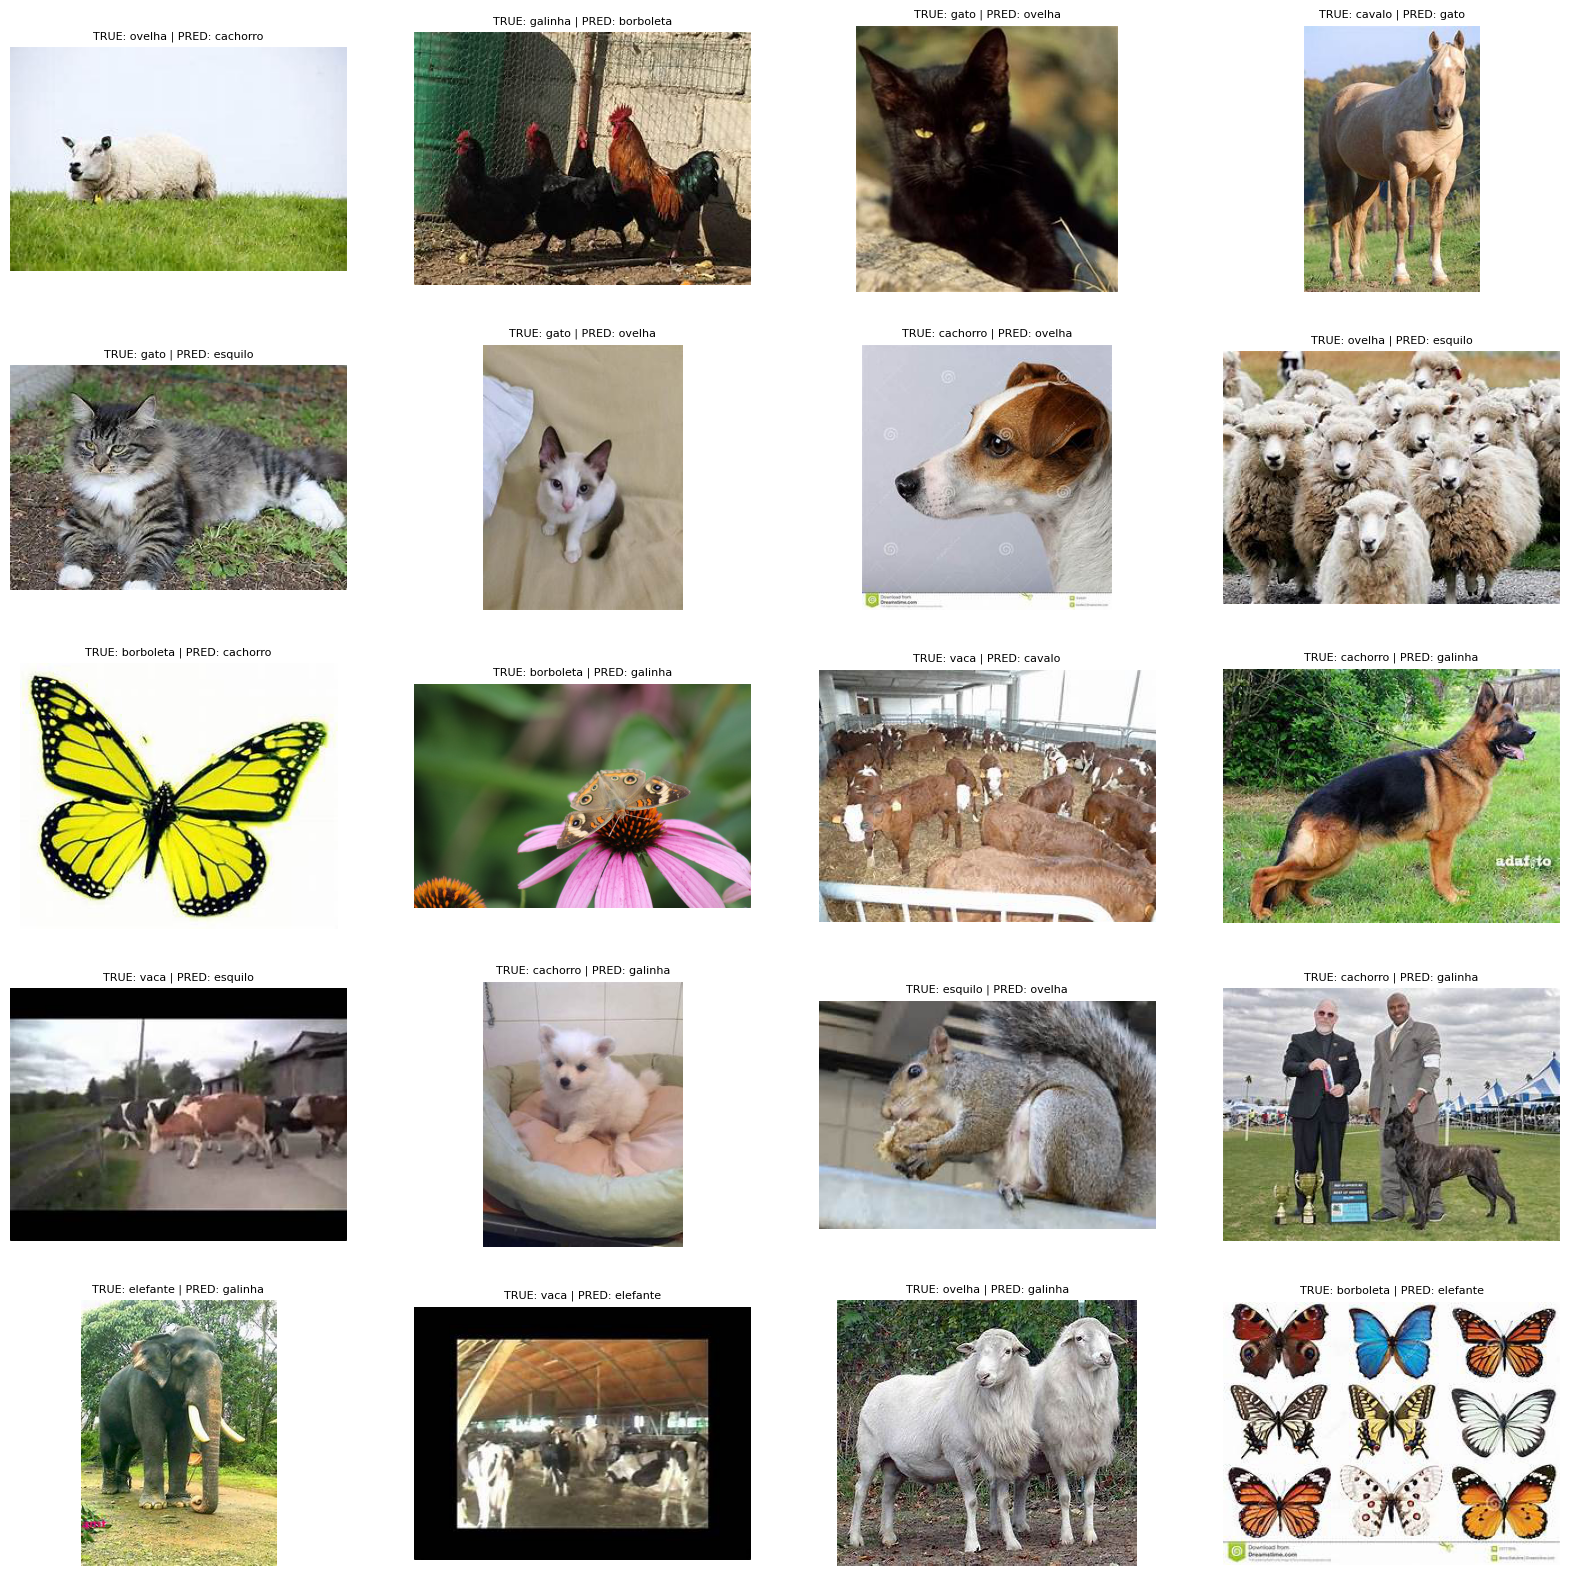

In [28]:
plt.figure(figsize=(20, 20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5, 4, i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()